## Code produit avec l'article: 
https://medium.com/h7w/implementing-a-variational-autoencoder-with-keras-e19d7140ad90

### Implémentation des valeurs de shapley

In [123]:
from keras.layers import Conv1D, Conv2D, Input, Flatten, Dense, MaxPooling1D, MaxPooling2D, BatchNormalization, Concatenate
from keras.optimizers import Adam
from keras import layers
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from PIL import Image
import copy
import numpy as np
import keras
import os
import re



In [124]:
# Fonction pour calculer les coordonées stéréographiques

def stereo(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Projection sur x y
    px = x / (1 + z + 1e-8)
    py = y / (1 + z + 1e-8)
    return px, py

# Importation des images

In [125]:
# Dossier contenant les images
repertoire = "../Render/captures"
img_width, img_height = 30, 30

# Expression pour extraire les infos du nom de fichier
#pattern = re.compile(r"img_tv(\d+)_pv(\d+)_tl(\d+)_pl(\d+)\.png") #all
pattern = re.compile(r"img_tv0_pv0_tl(\d+)_pl(\d+)\.jpg") #les images avec tv = 45 (la latitude moyenne)

# Stockage des résultats
images_info = []

for nom_fichier in os.listdir(repertoire):
    if nom_fichier.endswith(".jpg"):
        match = pattern.match(nom_fichier)
        if match:
            tl, pl = match.groups()
            tl, pl = int(tl), int(pl)
            px, py = stereo(np.radians(tl), np.radians(pl)) # Calcul des coordonnées stéréo
            chemin_image = os.path.join(repertoire, nom_fichier)
            image = Image.open(chemin_image)
            w, h = image.size
            left = (w - img_width) / 2
            top = (h - img_height) / 2
            right = (w + img_width) / 2
            bottom = (h + img_height) / 2
            #left, top, right, bottom = int(left), int(top), int(right), int(bottom)
            image = Image.open(chemin_image).crop((left, top, right, bottom))
            pixels = np.array(image, dtype=np.float32) / 255.0


            images_info.append({
                "tl": tl,
                "pl": pl,
                "px": px,
                "py": py,
                "image": image,
                "pixels": pixels,
            })

# Exemple : affichage d'une info
for info in images_info[:5]:  # juste les 5 premières
    print(f"tl={info['tl']}, pl={info['pl']}, px={info['px']}, py={info['py']}")

tl=75, pl=345, px=0.7411809490095723, py=-0.198598836732448
tl=75, pl=225, px=-0.5425821122771244, py=-0.5425821122771243
tl=60, pl=252, px=-0.17841104369713806, py=-0.5490927320369364
tl=30, pl=120, px=-0.13397459549759358, py=0.23205080632532074
tl=45, pl=160, px=-0.3892334257113643, py=0.14166938114040184


In [126]:
images_info[2]['image']

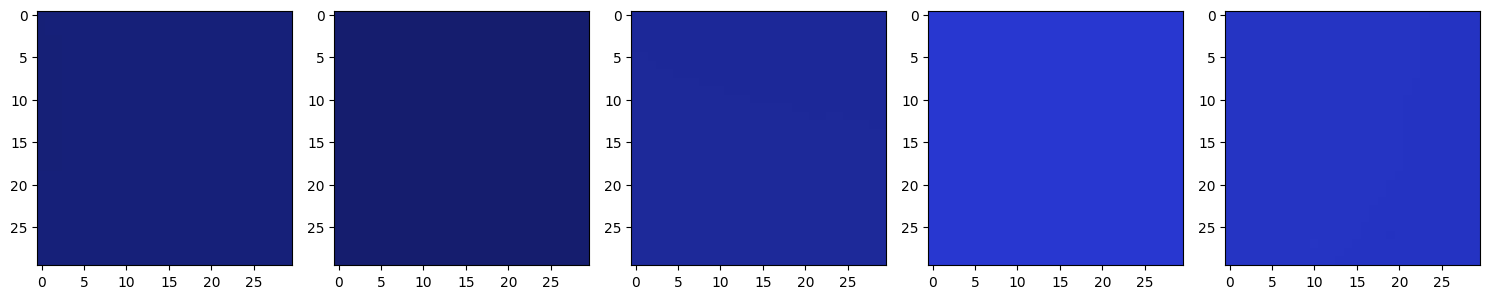

In [127]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

# On trie la liste

In [128]:
sorted = copy.deepcopy(images_info)
sorted.sort(key=lambda d: (d["tl"], d["pl"]))

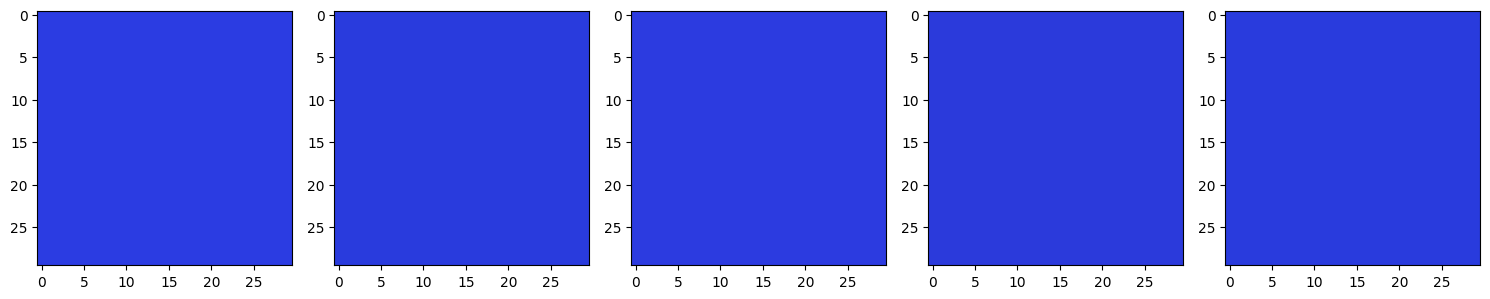

In [129]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(sorted[i]['pixels'])
plt.tight_layout()
plt.show()

# Cette fois ci visualisation de l'oraganisation des texels en fonctin des positions stéréo

In [130]:
# On prend le pixel le plus au centre
texel_row = img_height // 2
texel_col = img_width // 2
texel_position_str = f"({texel_row}, {texel_col})" # Pour l'affichage
print(texel_position_str)

(15, 15)


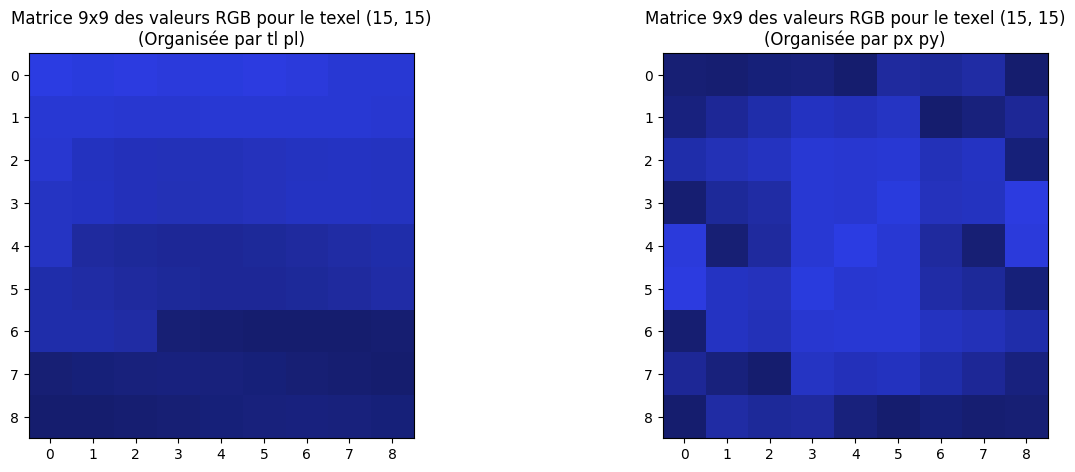

In [131]:
# Visualiser l'organisation de la matrice 9*9 en fonction du tri
# D'abord tl pl puis px, py
texel_angles = []
texel_stereo = []

images_angles = copy.deepcopy(images_info) # Copie pour le tri par angles
images_stereo = copy.deepcopy(images_info) # Copie pour le tri par stéréographiques


# Appliquer les tris aux copies distinctes
images_angles.sort(key=lambda d: (d["tl"], d["pl"]))
images_stereo.sort(key=lambda d: (d["px"], d["py"]))


for ang, ste in zip(images_angles, images_stereo):
    # info["pixels"] est le tableau NumPy 30x30x3 pour l'image entière de cette configuration angulaire
    texel_rgb_a = ang["pixels"][texel_row, texel_col, :]
    texel_rgb_s = ste["pixels"][texel_row, texel_col, :]
    texel_angles.append(texel_rgb_a)
    texel_stereo.append(texel_rgb_s)

# Convertir la liste en tableau NumPy
texel_angles_np = np.array(texel_angles, dtype=np.float32) # Forme (81, 3)
texel_stereo_np = np.array(texel_stereo, dtype=np.float32) # Forme (81, 3)

# Remodeler en matrice 9x9x3
mat_a = (texel_angles_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)
mat_s = (texel_stereo_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(mat_a)
axes[1].imshow(mat_s)
axes[0].set_title(f"Matrice 9x9 des valeurs RGB pour le texel {texel_position_str}\n(Organisée par tl pl)")
axes[1].set_title(f"Matrice 9x9 des valeurs RGB pour le texel {texel_position_str}\n(Organisée par px py)")
plt.show()


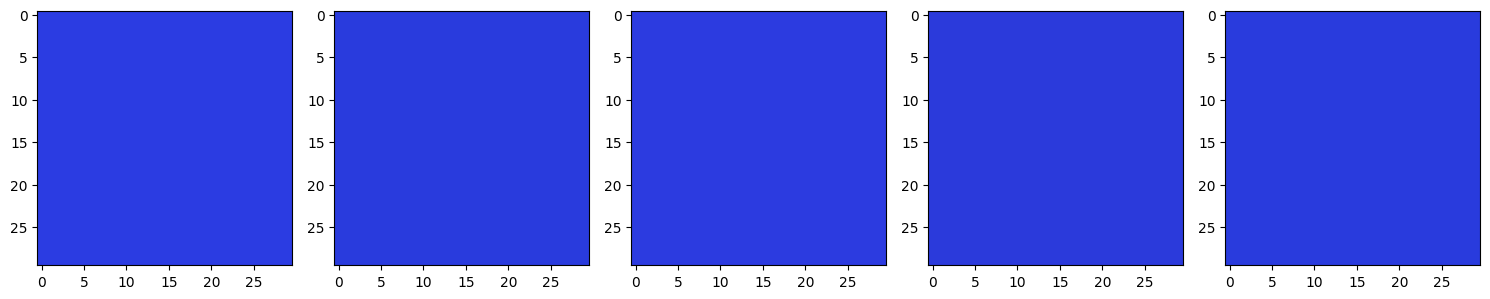

In [132]:
# Comme trier par les coordonnées stéréo sembl  plus adapté ici, c'est ce qu'on va choisir
images_info.sort(key=lambda d: (d["tl"], d["pl"]))
#images_info.sort(key=lambda d: (d["tl"], d["pl"]))
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

In [133]:
images_info[0]['pixels'][0, 0]

array([0.16862746, 0.23529412, 0.8862745 ], dtype=float32)

In [134]:
print("Premier pixel de la troisième image (R,G,B) :", images_info[2]['pixels'][0][0])
print("Nombre d'images importées:", len(images_info))

Premier pixel de la troisième image (R,G,B) : [0.17254902 0.23137255 0.8784314 ]
Nombre d'images importées: 81


# Création du modèles

In [223]:
latent_dim = 8 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
matrix_H = 9
matrix_W = 9

input_shape = (matrix_H, matrix_W, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1 (Conv1D -> Conv2D, MaxPooling1D -> MaxPooling2D)
x = Conv2D(filters = 64, kernel_size=(3, 3), padding='same', activation='relu')(i)
x = BatchNormalization()(x) #weight decay
x = MaxPooling2D(pool_size=(2, 2))(x)

# Bloc 2
x = Conv2D(filters = 128, kernel_size=(3, 3), padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Bloc 3
x = Conv2D(filters = 256, kernel_size=(3, 3), padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Bloc 4
x = Conv2D(filters = 512, kernel_size=(3, 3), padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)


# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder = Model(inputs=i, outputs=latent_output, name="Encoder")
encoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 9, 9, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 9, 9, 512)      │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 9, 9, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_output (Dense)           │ (None, 8)              │        65,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,928 (320.03 KB)

 Trainable params: 80,904 (316.03 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [224]:
# =================
# Decoder
# =================

# Paramètres
angle_dim = 2  # 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 2 = 10

# Entrée
decoder_input = Input(shape=(input_dim,), name='decoder_input')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input)

x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder_model = Model(inputs=decoder_input, outputs=decoder_output, name="Decoder")
decoder_model.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 106)            │         1,166 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rgb_output (Dense)              │ (None, 3)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,513 (138.72 KB)

 Trainable params: 35,513 (138.72 KB)

 Non-trainable params: 0 (0.00 B)

In [225]:
# =================
# Modele
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder(i)
decoder_input = Concatenate()([latent_vector, view_light_input])
model_outputs = decoder_model(decoder_input)

model = Model(inputs=[i, view_light_input], outputs=model_outputs, name='Modele')
model.summary()

Model: "Modele"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 9, 9, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder             │ (None, 8)         │     81,928 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 10)        │          0 │ Encoder[0][0],    │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 3)         │     35,513 │ concatenate_5[0]… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 117,441 (458.75 KB)

 Trainable params: 116,417 (454.75 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [226]:
# --- L2 Loss ---
def custom_reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


# Compilation et entraînement
Sur un seul texel pour commencer

In [227]:
# on prend toutes les images
image_stack = np.stack([info["pixels"] for info in images_info], axis=0)
# image_stack.shape = (N_images, height, width, 3)

In [228]:
# on fait de même avec les angles
tl_stack = np.stack([info["tl"] for info in images_info], axis=0)
pl_stack = np.stack([info["pl"] for info in images_info], axis=0)

# et pour les positions stéréo
px_stack = np.stack([info["px"] for info in images_info], axis=0)
py_stack = np.stack([info["py"] for info in images_info], axis=0)

In [229]:
num_pixels = img_height*img_width
image_stack_padded = image_stack.reshape((samples, num_pixels, num_channels))

In [230]:
# Préparation des données

# On prend toutes les ABRDF par texel
num_pixels = img_height*img_width
image_stack_padded = image_stack.reshape((samples, num_pixels, num_channels))

texel_observations = np.zeros((num_pixels, samples, num_channels))
texel_observations = np.transpose(image_stack_padded, (1, 0, 2)) # Pour avoir les informations par pixel, on inverse juste les axes
print("Forme de image_stack_padded:", image_stack_padded.shape)
print("Forme de texel_observations:", texel_observations.shape)

Forme de image_stack_padded: (81, 900, 3)
Forme de texel_observations: (900, 81, 3)


In [231]:
padded_observations = np.zeros((num_pixels, matrix_H * matrix_W, num_channels))
padded_observations[:len(texel_observations)] = texel_observations
input_train_batch_2d = padded_observations.reshape((num_pixels, matrix_H, matrix_W, num_channels))

In [232]:
light_dirs = np.stack([px_stack, py_stack], axis=1) # Forme (81, 2)
rep_light_dirs = np.tile(light_dirs, (num_pixels, 1, 1))
target_rgb_train = texel_observations  # (900, 81, 3)

In [233]:
input_train_batch_2d.shape, rep_light_dirs.shape, target_rgb_train.shape

((900, 9, 9, 3), (900, 81, 2), (900, 81, 3))

In [234]:
# Restructuration des données pour le nouveau scénario

# Entrée pour l'encodeur (l'image "visuelle" du pixel)
# Pour chaque (pixel, sample), nous devons associer l'image du pixel correspondant.
# Nous allons répéter chaque image de pixel `samples` fois.
reshaped_input_train_batch_2d = np.repeat(input_train_batch_2d, samples, axis=0)
# Nouvelle forme: (num_pixels * samples, matrix_H, matrix_W, num_channels)
# Ex: (72900, 9, 9, 3)

# Entrée pour le décodeur (la direction de lumière)
# Nous aplatissons les samples pour avoir une direction par ligne d'entraînement.
reshaped_light_dirs = rep_light_dirs.reshape(-1, 2)
# Nouvelle forme: (num_pixels * samples, 2)
# Ex: (72900, 2)

# Sortie attendue (la couleur RGB)
# Nous aplatissons les samples pour avoir une couleur par ligne d'entraînement.
reshaped_target_rgb_train = target_rgb_train.reshape(-1, 3)
# Nouvelle forme: (num_pixels * samples, 3)
# Ex: (72900, 3)

reshaped_input_train_batch_2d.shape, reshaped_light_dirs.shape, reshaped_target_rgb_train.shape


((72900, 9, 9, 3), (72900, 2), (72900, 3))

# Pre train avant d'utiliser les valeurs de shapley

In [ ]:
custom_optimizer = Adam(learning_rate=0.01) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
model.compile(custom_optimizer, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

history = model.fit(
    [reshaped_input_train_batch_2d, reshaped_light_dirs], # Keras gère le batch_size automatiquement
    reshaped_target_rgb_train,
    epochs=30,
    batch_size=5, # Keras va prendre 5 pixels à la fois et les passer à l'encodeur/décodeur
    validation_split=0.2
)


Epoch 1/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.0857 - val_loss: 0.0082
Epoch 2/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 3/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 4/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 5/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 6/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 7/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 8/30
11664/11664 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 9/30
 7163/11664 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0083

dict_keys(['loss', 'val_loss'])


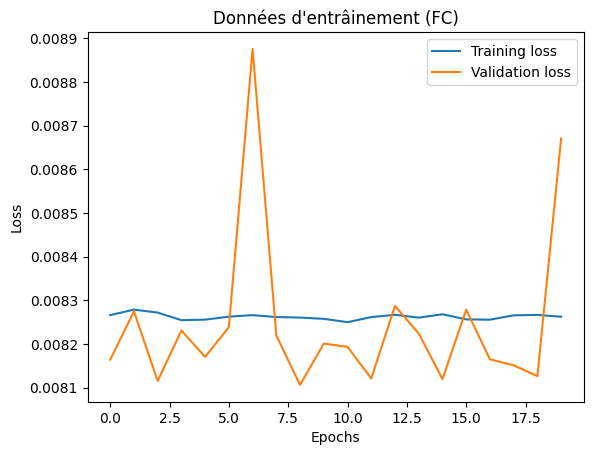

In [214]:
# Evaluer l'apprentissage d'un modèle --Code: Patrick Reuter--
def montrerCourbesApprentissage(history):
    #list all data in history
    print(history.history.keys())

    plt.plot(history.history['loss'][10:], label="Training loss")
    plt.plot(history.history['val_loss'][10:], label="Validation loss")

    plt.title("Données d'entrâinement (FC)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

montrerCourbesApprentissage(history)

# Visualisation des poids

In [34]:
model_save_path = os.path.join('modeles/', 'my_model.h5')
model.save(model_save_path)
print(f"Modèle sauvegardé à : {model_save_path}")


deco_save_path = os.path.join('modeles/', 'my_deco_model.h5')
decoder_model.save(deco_save_path)
print(f"Modèle deco sauvegardé à : {deco_save_path}")

decoder_weights_path = os.path.join('modeles/', 'my_decoder_after.weights.h5')
decoder_model.save_weights(decoder_weights_path)
print(f"Poids de l'Encodeur sauvegardés à : {decoder_weights_path}")

Modèle vae sauvegardé à : modeles/my_vae_model.h5
Modèle deco sauvegardé à : modeles/my_deco_model.h5
Poids de l'Encodeur sauvegardés à : modeles/my_decoder_after.weights.h5


In [191]:
input_train_batch_2d[0].shape

(9, 9, 3)

In [198]:
encoder.predict(input_train_batch_2d)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[ 24.2257  , -44.72478 ],
       [ 24.227654, -44.726192],
       [ 24.24409 , -44.728966],
       ...,
       [ 24.269243, -44.723015],
       [ 24.253485, -44.7187  ],
       [ 24.250523, -44.71616 ]], dtype=float32)

# Prédicitions d'un texel avec toutes les dimensions

In [219]:
target_rgb_train[0, 3]

array([0.16862746, 0.22745098, 0.85882354], dtype=float32)

In [221]:
encoder.predict(input_train_batch_2d)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[-175.32103, -865.037  ],
       [-175.249  , -864.97516],
       [-175.36339, -864.85864],
       ...,
       [-175.64064, -865.42773],
       [-175.43004, -865.3319 ],
       [-175.56494, -865.4386 ]], dtype=float32)

In [220]:
latent_vector

array([-175.32103, -865.037  ], dtype=float32)

In [222]:
lum_index = 3
pixel_index = 0
light_direction =light_dirs[lum_index]

latent_vector = encoder.predict(input_train_batch_2d)[pixel_index]  # (8,)

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = decoder_model.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train[pixel_index, lum_index])

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted RGB: [[0.11613407 0.1657465  0.61225903]] Original [0.16862746 0.22745098 0.85882354]


In [177]:
light_direction

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.31652497e-01,  0.00000000e+00],
       [ 6.58262485e-02,  1.14014407e-01],
       [-6.58262485e-02,  1.14014407e-01],
       [-1.31652497e-01,  1.61227809e-17],
       [-6.58262485e-02, -1.14014407e-01],
       [ 6.58262485e-02, -1.14014407e-01],
       [ 2.67949191e-01,  0.00000000e+00],
       [ 2.32050806e-01,  1.33974595e-01],
       [ 1.33974595e-01,  2.32050806e-01],
       [ 1.64071560e-17,  2.67949191e-01],
       [-1.33974595e-01,  2.32050806e-01],
       [-2.32050806e-01,  1.33974595e-01],
       [-2.67949191e-01,  3.28143119e-17],
       [-2.32050806e-01, -1.33974595e-01],
       [-1.33974595e-01, -2.32050806e-01],
       [-4.92214679e-17, -2.67949191e-01],
       [ 1.33974595e-01, -2.32050806e-01],
       [ 2.32050806e-01, -1.33974595e-01],
       [ 4.14213560e-01,  0.00000000e+00],
       [ 3.89233426e-01,  1.41669381e-01],
       [ 3.17305996e-01,  2.66251344e-01],
       [ 2.07106780e-01,  3.58719466e-01],
       [ 7.

# Prédicitions d'un texel avec une configuration spécifique

In [199]:
latent_vector = encoder.predict(input_train_batch_2d)[0]  # (8,)
latent_vector

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


array([ 24.2257 , -44.72478], dtype=float32)

In [54]:
latent_vector

array([-2.6527715,  0.7626627], dtype=float32)

In [ ]:
# Générer carte latente composée de tous les vecteurs latent par texel
latent_map = np.zeros((img_height, img_width, latent_dim), dtype=np.float32)

for y in range(img_height):
    for x in range(img_width):
        texel_rgb_values_all_configs = image_stack[:, y, x, :] # (num_angles, 3)
        input_encoder_for_texel = texel_rgb_values_all_configs.reshape((matrix_H, matrix_W, num_channels)) # (9, 9, 3)
        
        # Ajouter une dimension de batch (batch_size=1)
        input_encoder_for_texel_batch = np.expand_dims(input_encoder_for_texel, axis=0) # (1, 9, 9, 3)

        # Prédire le vecteur latent
        latent_vector = encoder.predict(input_encoder_for_texel_batch, verbose=0)[0] # (8,)
        latent_map[y, x] = latent_vector

print(f"Forme de la carte latente: {latent_map.shape}")

Forme de la carte latente: (50, 50, 2)


In [40]:
latent_map

array([[[-2.6544917 ,  0.75440544],
        [-2.6495483 ,  0.75268877],
        [-2.6495483 ,  0.75268877],
        ...,
        [-2.6354008 ,  0.7478549 ],
        [-2.6354008 ,  0.7478549 ],
        [-2.6424768 ,  0.7487308 ]],

       [[-2.6542563 ,  0.7525589 ],
        [-2.6491065 ,  0.75051665],
        [-2.6491065 ,  0.75051665],
        ...,
        [-2.634659  ,  0.74553317],
        [-2.634659  ,  0.74553317],
        [-2.641812  ,  0.7464639 ]],

       [[-2.6542563 ,  0.7525589 ],
        [-2.6491733 ,  0.7523717 ],
        [-2.6491733 ,  0.7523717 ],
        ...,
        [-2.634659  ,  0.74553317],
        [-2.634659  ,  0.74553317],
        [-2.641812  ,  0.7464639 ]],

       ...,

       [[-2.6332026 ,  0.7730672 ],
        [-2.6355517 ,  0.7715201 ],
        [-2.6355517 ,  0.7715201 ],
        ...,
        [-2.641244  ,  0.75574064],
        [-2.641244  ,  0.75574064],
        [-2.6534474 ,  0.7639443 ]],

       [[-2.6332026 ,  0.7730672 ],
        [-2.6355517 ,  0.77

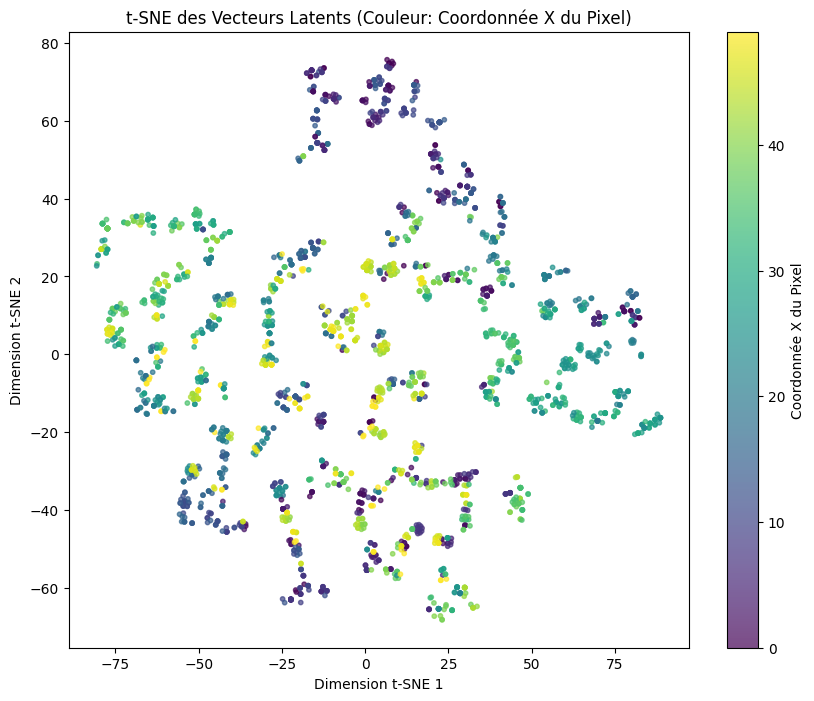

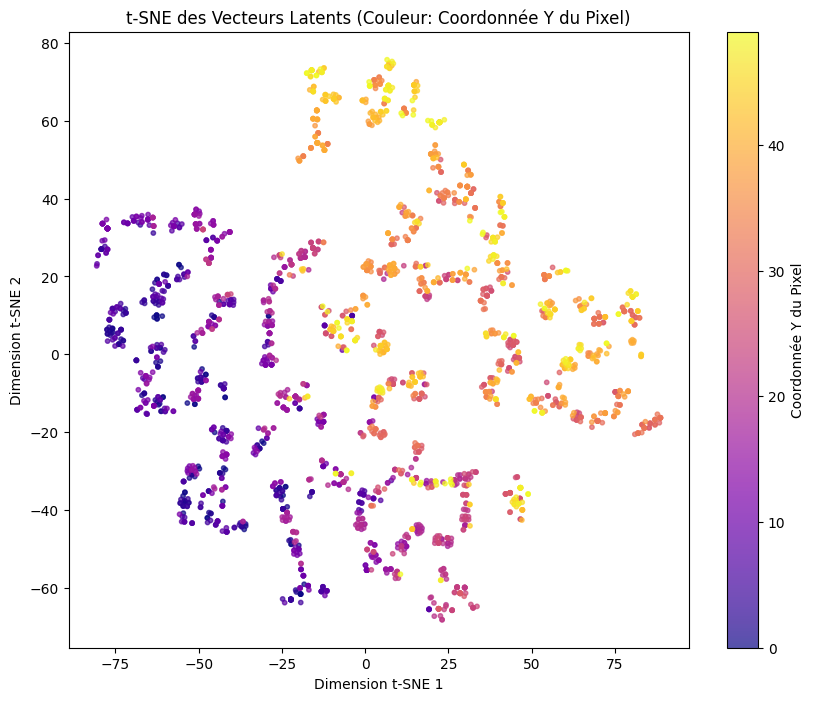

In [41]:
# Nécessite scikit-learn pour t-SNE ou umap-learn pour UMAP
# pip install scikit-learn
# pip install umap-learn (si vous préférez UMAP, souvent plus rapide)

from sklearn.manifold import TSNE # Ou import umap

# --- Préparation des données pour t-SNE ---
# Redimensionner la carte latente pour avoir une liste de vecteurs latents
# Chaque ligne est un vecteur latent pour un pixel
all_latent_vectors = latent_map.reshape(-1, latent_dim) # (img_height * img_width, latent_dim)

# Garder trace des coordonnées originales des pixels pour la coloration
pixel_coords = np.array([(x, y) for y in range(img_height) for x in range(img_width)])

# --- Application de t-SNE ---
# Réduit les vecteurs latents à 2 dimensions
# t-SNE est coûteux en calcul pour de très grands ensembles de données
# n_components=2 pour une visualisation 2D, n_components=3 pour une 3D
tsne = TSNE(n_components=2, random_state=42, verbose=0)
latent_vectors_2d = tsne.fit_transform(all_latent_vectors)

# --- Visualisation 2D (la plus courante pour t-SNE) ---
plt.figure(figsize=(10, 8))
# Colorer par la coordonnée X du pixel
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1],
            c=pixel_coords[:, 0], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(label='Coordonnée X du Pixel')
plt.title('t-SNE des Vecteurs Latents (Couleur: Coordonnée X du Pixel)')
plt.xlabel('Dimension t-SNE 1')
plt.ylabel('Dimension t-SNE 2')
plt.show()

# Vous pouvez faire une deuxième visualisation en colorant par la coordonnée Y
plt.figure(figsize=(10, 8))
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1],
            c=pixel_coords[:, 1], cmap='plasma', s=10, alpha=0.7)
plt.colorbar(label='Coordonnée Y du Pixel')
plt.title('t-SNE des Vecteurs Latents (Couleur: Coordonnée Y du Pixel)')
plt.xlabel('Dimension t-SNE 1')
plt.ylabel('Dimension t-SNE 2')
plt.show()

In [ ]:
#HEAT MAP
# Exemple de visualisation de cartes de chaleur pour les dimensions latentes
# en utilisant la latent_map générée précédemment

num_latent_dims_to_plot = min(latent_dim, 4) # Limiter pour ne pas avoir trop de plots

fig, axes = plt.subplots(1, num_latent_dims_to_plot, figsize=(4 * num_latent_dims_to_plot, 5))
if num_latent_dims_to_plot == 1: # Pour éviter les erreurs d'indexation si 1 seul subplot
    axes = [axes]

for i in range(num_latent_dims_to_plot):
    ax = axes[i]
    # Afficher la i-ème dimension latente comme une image 2D
    im = ax.imshow(latent_map[:, :, i], cmap='viridis', origin='lower')
    ax.set_title(f'Dim Latente {i}')
    ax.set_xlabel('X Pixel')
    ax.set_ylabel('Y Pixel')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # Ajuster la barre de couleur

plt.tight_layout()
plt.suptitle('Cartes de Chaleur des Dimensions Latentes', y=1.02, fontsize=16)
plt.show()